In [44]:
from compute import Model, Var, Par, RefNode, adda, addsolver, ureg, get_unit, buildidpvars, coupled_run, Evaluable, args_in_order, fill_args, unit_conversion_factors, evaluable_with_unit
from compute import geteqs
from inputresolver import reassigneq, eqvars, eqsonly, default_out, mdf_order, default_in, idx_eqlist
from inputresolver import getallvars, invert_edges, resolve, reassign, flatten_order
from notation import graphs_from_incidence, make_acyclic, solvers_bottom_up, generate_execution, default_sequence
from representations import bipartite_repr, drawbipartite, digraph_repr, draw, draw_dsm, render_tree, tree_incidence
from compute_utils import get_outputs, check_eqs, print_out
from partitioner import default_out_condensation, merge
from pprint import pprint
import networkx as nx
import sympy as sp
from sympy.utilities.lambdify import implemented_function
import numpy as np
from scipy import interpolate
import openmdao.api as om
#import gpkit as gp
#import cvxpy as cp
import matplotlib.patches as patches
import matplotlib.pyplot as plt

In [49]:
model = Model()
m = RefNode(name='/', ref=model)
loop = addsolver(m, [], [], name='loop')

In [50]:
m_l1 = Par('m_l1', 100, 'kg')
m_l2 = Par('m_l2', 100, 'kg')
m_l3 = Par('m_l3', 100, 'kg')
m_s1 = Par('m_s1', 10, 'kg')
m_s2 = Par('m_s2', 10, 'kg')
m_t = Var('m_t', unit='kg')
v_exh = Par('v_e', 4000, 'm/s')
alpha = Par('alpha', 0.1)
m_s3 = adda(loop, 'm_s3', alpha*m_t)
adda(loop, m_t, m_l1+m_s1+m_l2+m_s2+m_l3+m_s3)
m_i1 = adda(m, 'm_i1', m_t)
m_f1 = adda(m, 'm_f1', m_i1-m_l1)
dv1 = adda(m, '\\Delta v_1', v_exh*sp.log(m_i1/m_f1))
m_i2 = adda(m, 'm_i2', m_f1-m_s1)
m_f2 = adda(m, 'm_f2', m_i2-m_l2)
dv2 = adda(m, '\\Delta v_2', v_exh*sp.log(m_i2/m_f2))
m_i3 = adda(m, 'm_i3', m_f2-m_s2)
m_f3 = adda(m, 'm_f3', m_i3-m_l3)
dv3 = adda(m, '\\Delta v_3', v_exh*sp.log(m_i3/m_f3))
dvtot = adda(m, 'Delta_v', dv1+dv2+dv3)

In [51]:
render_tree(m)

/               
├── loop        
│   ├── f_{0}   
│   └── f_{1}   
├── f_{2}       
├── f_{3}       
├── f_{4}       
├── f_{5}       
├── f_{6}       
├── f_{7}       
├── f_{8}       
├── f_{9}       
├── f_{10}      
└── f_{11}      


In [52]:
eqs, eqv, dout, dins = model.data_structures()
sequence_m = default_sequence(m)

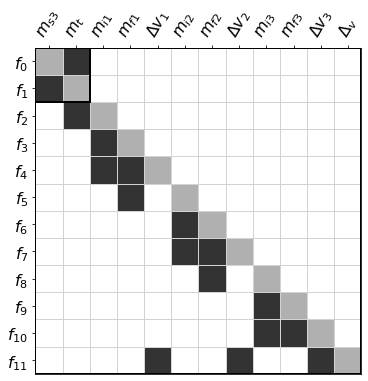

In [53]:
fig, ax = tree_incidence(m, eqv, model.outset, sequence_m, figsize=(6,6), showtree=False, pad=0);
plt.sca(ax)
plt.savefig('figures/rocket.png', dpi=600, bbox_inches='tight')

In [4]:
eqs = idx_eqlist(alleqs)
eqv = eqvars(eqs)
dout = default_out(eqs)
dins = default_in(eqs, count_never_output=False)

In [5]:
eqv_noparams = {elt:{key for key in keys if not key.never_output} for elt,keys in eqv.items()}
DG, edges = digraph_repr(eqv_noparams, dout, intermediary=False)

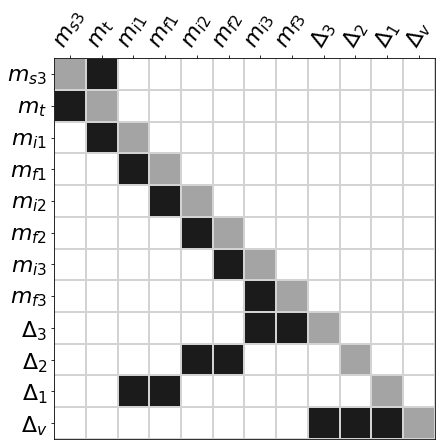

In [9]:
order = mdf_order(eqv, dout)
plt.figure(figsize=(7,7))
ax = draw_dsm(DG, flatten_order(order), dout,  fontsize=22)
#rect2 = patches.Rectangle((22, 22), 2, 2, linewidth=2, edgecolor='k', facecolor='none')
# Add the patch to the Axes
#ax.add_patch(rect2);
plt.savefig('rocket.png', dpi=600)

In [81]:
prob = om.Problem()
model = prob.model
dins = default_in(eqs)
buildidpvars(dins, model)
counter = coupled_run(eqs, order, (), model, model, debug=True)
prob.setup()
prob.set_solver_print(level=0)
prob.set_val('alpha', 0.6)
prob.run_model()

eq0 m_s3 alpha*m_t None
eq1 m_t m_l1 + m_l2 + m_l3 + m_s1 + m_s2 + m_s3 None
eq2 m_i1 m_t None
eq3 m_f1 m_i1 - m_l1 None
eq5 m_i2 m_f1 - m_s1 None
eq6 m_f2 m_i2 - m_l2 None
eq8 m_i3 m_f2 - m_s2 None
eq9 m_f3 m_i3 - m_l3 None
eq10 Delta_3 v_e*log(m_i3/m_f3) None
eq7 Delta_2 v_e*log(m_i2/m_f2) None
eq4 Delta_1 v_e*log(m_i1/m_f1) None
eq11 Delta_v Delta_1 + Delta_2 + Delta_3 None
m_s3 [0.6]
m_t [320.6]
m_s3 [192.36]
m_t [320.6]
m_s3 [480.]
m_t [800.]
m_s3 [480.]
m_t [800.]
m_i1 [800.]
m_f1 [700.]
m_i2 [690.]
m_f2 [590.]
m_i3 [580.]
m_f3 [480.]
Delta_3 [756.96799855]
Delta_2 [626.27624277]
Delta_1 [534.1255705]
Delta_v [1917.36981182]


In [74]:
model.list_outputs();

18 Explicit Output(s) in 'model'

varname      val            
-----------  ---------------
inp
  m_s1       [10.]          
  m_s2       [10.]          
  v_e        [4000.]        
  m_l2       [100.]         
  m_l3       [100.]         
  m_l1       [100.]         
group1
  group2
    eq0
      m_s3   [35.55555556]  
    eq1
      m_t    [355.55555556] 
  eq2
    m_i1     [355.55555556] 
  eq3
    m_f1     [255.55555556] 
  eq5
    m_i2     [245.55555556] 
  eq6
    m_f2     [145.55555556] 
  eq8
    m_i3     [135.55555556] 
  eq9
    m_f3     [35.55555556]  
  eq10
    Delta_3  [5353.14056773]
  eq7
    Delta_2  [2091.86151327]
  eq4
    Delta_1  [1320.96674748]
  eq11
    Delta_v  [8765.96882848]


0 Implicit Output(s) in 'model'


